In [ ]:
import autorootcwd
import torch
from src.data.NTU_dataset import NTU
from src.data.transforms import init_transform_dict
tsfm_params = {}
tsfm_dict = init_transform_dict(**tsfm_params)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


dataset = NTU(
    dataset_name="NTU",
    text_params={'input': 'text'},
    video_params={
        'extraction_fps': 25,
        'extraction_res': 256,
        'input_res': 224,
        'num_frames': 4,
        'stride': 1
    },
    data_dir="data/nturgbd",
    metadata_dir="data/nturgbd",
    split='train',
    tsfms=tsfm_dict['test'],
    cut=None,
    subsample=1,
    sliding_window_stride=-1,
    reader='decord'
)

In [126]:
from src.model.model_yeonjae import FiT

model = FiT(
    video_params={
        'model': 'SpaceTimeTransformer',
        'num_frames': 4,
        'arch_config': 'base_patch16_224',
        'vit_init': 'imagenet-21k',
        'attention_style': 'frozen-in-time',
        'pretrained': True
    },
    text_params={'model': 'distilbert-base-uncased', 'pretrained': True},
    projection_dim=256
).to(device)

######USING ATTENTION STYLE:  frozen-in-time


In [6]:
from src.model.model_yeonjae import FiT

model = FiT(
    video_params={"model": "SpaceTimeTransformer", "num_frames": 4,
                  "arch_config":"base_patch16_224", "vit_init": "imagenet-21k",
                  "attention_style":"frozen-in-time", "pretrained":True},
    text_params={"model": "distilbert-base-uncased", "pretrained": True},
    projection_dim=256,
    load_checkpoint=None
).to(device)

import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

checkpoint = torch.load("src/exps/pretrained/cc-webvid2m-4f_stformer_b_16_224.pth.tar", 
                        map_location=device)
model.load_state_dict(checkpoint['state_dict'], strict=False)

pathlib.PosixPath = temp

######USING ATTENTION STYLE:  frozen-in-time


C:\Users\user\AppData\Local\Temp\ipykernel_39748\2895275361.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("src/exps/pretrained/cc-webvid2m-4f_

In [7]:
import pandas as pd

df = pd.read_csv('data/nturgbd/annotations.csv')

with open('data/nturgbd/splits/train_list.txt', 'r') as f:
    test_videos = set(line.strip() for line in f)

actions = {
    'hand_waving': [],
    'put_on_jacket': [], 
    'take_off_jacket': [],
    'drink_water': []
}

for action in actions.keys():
    action_df = df[df['caption'] == action]
    for _, row in action_df.iterrows():
        video_id = row['video_id']
        if video_id in test_videos and len(actions[action]) < 48:
            actions[action].append(video_id)

print("액션별 test 비디오 ID:")
for action, video_ids in actions.items():
    print(f"{action}: {video_ids}")

액션별 test 비디오 ID:
hand_waving: ['S017C001P003R001A023_rgb', 'S017C001P003R002A023_rgb', 'S017C001P007R001A023_rgb', 'S017C001P007R002A023_rgb', 'S017C001P008R002A023_rgb', 'S017C001P009R001A023_rgb', 'S017C001P009R002A023_rgb', 'S017C001P015R001A023_rgb', 'S017C001P015R002A023_rgb', 'S017C001P016R001A023_rgb', 'S017C001P016R002A023_rgb', 'S017C001P017R002A023_rgb', 'S017C001P020R001A023_rgb', 'S017C001P020R002A023_rgb', 'S017C002P003R001A023_rgb', 'S017C002P003R002A023_rgb', 'S017C002P007R001A023_rgb', 'S017C002P008R001A023_rgb', 'S017C002P008R002A023_rgb', 'S017C002P009R001A023_rgb', 'S017C002P009R002A023_rgb', 'S017C002P017R001A023_rgb', 'S017C002P017R002A023_rgb', 'S017C002P020R001A023_rgb', 'S017C002P020R002A023_rgb', 'S017C003P003R001A023_rgb', 'S017C003P003R002A023_rgb', 'S017C003P007R001A023_rgb', 'S017C003P007R002A023_rgb', 'S017C003P008R001A023_rgb', 'S017C003P009R001A023_rgb', 'S017C003P009R002A023_rgb', 'S017C003P015R002A023_rgb', 'S017C003P016R001A023_rgb', 'S017C003P017R001

In [8]:
video_to_index = {}
for idx in range(len(dataset)):
    video_id = dataset.metadata.index[idx]
    video_to_index[video_id] = idx

for action, video_ids in actions.items():
    for i, video_id in enumerate(video_ids, 1):
        if video_id in video_to_index:
            idx = video_to_index[video_id]
            video_tensor = dataset[idx]['video'].to(device).unsqueeze(0)
            globals()[f"{action}_{i}"] = video_tensor


In [10]:
import numpy as np
import torch

embeddings = []
labels = []
action_videos = {}

for action, video_ids in actions.items():
    videos = []
    for video_id in video_ids:
        if video_id in video_to_index:
            idx = video_to_index[video_id]
            video_tensor = dataset[idx]['video'].to(device)
            videos.append(video_tensor)
    action_videos[action] = videos

model.eval()
with torch.no_grad():
    for action, videos in action_videos.items():
        print(f"Processing {action}...")
        for i, video in enumerate(videos):
            video_embedding = model.compute_video(video.unsqueeze(0))

            embeddings.append(video_embedding.cpu().detach().numpy())
            labels.append(action)

            del video_embedding
            torch.cuda.empty_cache()

embeddings = np.vstack(embeddings)
print(f"최종 embeddings 형태: {embeddings.shape}")

Processing hand_waving...
Processing put_on_jacket...
Processing take_off_jacket...
Processing drink_water...
최종 embeddings 형태: (152, 256)


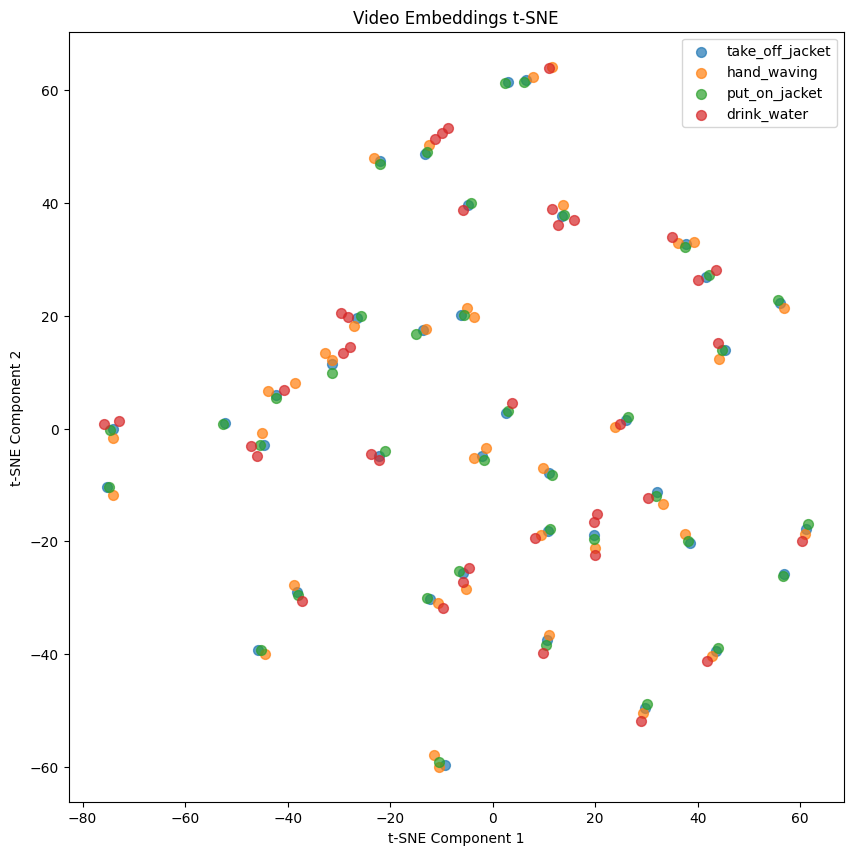

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

embeddings_np = []
for emb in embeddings:
    if hasattr(emb, 'cpu'):
        embeddings_np.append(emb.cpu().detach().numpy())
    else:
        embeddings_np.append(emb)

embeddings_array = np.vstack(embeddings_np)

tsne = TSNE(n_components=2, perplexity=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_array)

plt.figure(figsize=(10, 10))
unique_labels = list(set(labels))
colors = plt.cm.tab10(range(len(unique_labels)))

for i, lab in enumerate(unique_labels):
    idxs = [j for j, l in enumerate(labels) if l == lab]
    plt.scatter(embeddings_2d[idxs, 0], embeddings_2d[idxs, 1], 
                c=[colors[i]], label=lab, s=50, alpha=0.7)

plt.legend()
plt.title('Video Embeddings t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [19]:
from transformers import AutoModel
import torch.nn as nn
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

text_data = "sitting"

text_data = tokenizer(
    text_data,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=tokenizer.model_max_length
).to(device)

text_embeddings = model.compute_text(text_data)
print(text_embeddings.shape)

torch.Size([1, 256])


In [ ]:
video_embeds = embeddings_array.astype('float32')

paired_texts = labels

tok = tokenizer(
    paired_texts,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=tokenizer.model_max_length
).to(device)

model.eval()
with torch.no_grad():
    text_embeds = model.compute_text(tok).detach().cpu().numpy().astype('float32')

N = video_embeds.shape[0]
print(video_embeds.shape, text_embeds.shape, N)


(152, 256) (152, 256) 152


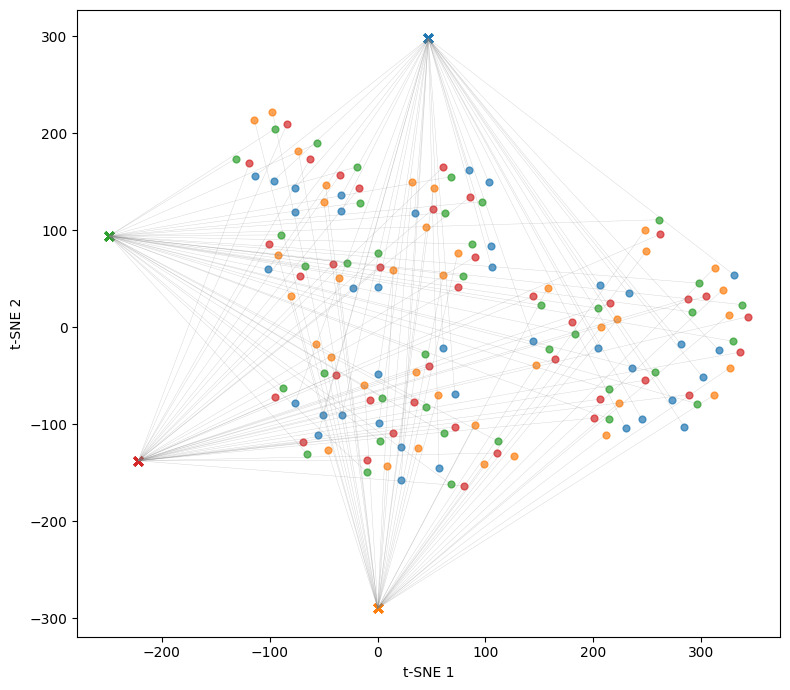

In [32]:
import numpy as np, matplotlib.pyplot as plt, torch, torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from math import sqrt

Vn = F.normalize(torch.from_numpy(video_embeds), dim=1).numpy()
Tn = F.normalize(torch.from_numpy(text_embeds), dim=1).numpy()

X  = np.vstack([Vn, Tn])
Xn = StandardScaler().fit_transform(X)
N  = Vn.shape[0]
Z_v, Z_t = Xn[:N], Xn[N:]

# ---------- t-SNE ----------
perp = max(5, min(30, int(sqrt(N))))
Zts = TSNE(n_components=2, perplexity=perp, init="pca", learning_rate="auto", random_state=0)\
        .fit_transform(np.vstack([Z_v, Z_t]))
Zv_ts, Zt_ts = Zts[:N], Zts[N:]

plt.figure(figsize=(8,7))
for lab in uniq:
    idxs = [i for i, l in enumerate(labels) if l == lab]
    plt.scatter(Zv_ts[idxs,0], Zv_ts[idxs,1], s=24, alpha=0.7, c=[cmap[lab]], label=f"{lab} (video)")
    plt.scatter(Zt_ts[idxs,0], Zt_ts[idxs,1], s=34, alpha=0.9, marker='x', c=[cmap[lab]], label=f"{lab} (text)")
for i in range(N):
    plt.plot([Zv_ts[i,0], Zt_ts[i,0]], [Zv_ts[i,1], Zt_ts[i,1]], lw=0.3, alpha=0.35, c='gray')
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2"); plt.tight_layout(); plt.show()
